## Pre-processing
- One-hot encode categorical variables.
- Train/test split your data.
- Scale your data.
- Consider using automated feature selection.

## Modeling
- **Establish your baseline score.**
- Fit linear regression. Look at your coefficients. Are any of them wildly overblown?
- Fit lasso/ridge/elastic net with default parameters.
- Go back and remove features that might be causing issues in your models.
- Tune hyperparameters.
- **Identify a production model.** (This does not have to be your best performing Kaggle model, but rather the model that best answers your problem statement.)
- Refine and interpret your production model.

## Inferential Visualizations
- Look at feature loadings.
- Look at how accurate your predictions are.
- Is there a pattern to your errors? Consider reworking your model to address this.

## Business Recommendations
- Which features appear to add the most value to a home?
- Which features hurt the value of a home the most?
- What are things that homeowners could improve in their homes to increase the value?
- What neighborhoods seem like they might be a good investment?
- Do you feel that this model will generalize to other cities? How could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?

```
project-2
|__ code
|   |__ 01_EDA_and_Cleaning.ipynb   
|   |__ 02_Preprocessing_and_Feature_Engineering.ipynb   
|   |__ 03_Model_Benchmarks.ipynb
|   |__ 04_Model_Tuning.ipynb  
|   |__ 05_Production_Model_and_Insights.ipynb
|   |__ 06_Kaggle_Submissions.ipynb   
|__ data
|   |__ train.csv
|   |__ test.csv
|   |__ submission_lasso.csv
|   |__ submission_ridge.csv
|__ images
|   |__ coefficients.png
|   |__ neighborhoods.png
|   |__ predictions.png
|__ presentation.pdf
|__ README.md
```

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
#Get cleaned datasets: Not touching main test set first
test = '../datasets/test_cleaned.csv'
train = '../datasets/train_cleaned.csv'

In [3]:
# Read csv the clean files
test = pd.read_csv(test)
train = pd.read_csv(train)
train.drop('Unnamed: 0',axis = 1,inplace=True)
test.drop('Unnamed: 0',axis = 1,inplace=True)
# Combine train and test scores first
df = pd.concat([test,train],ignore_index=True,sort=False)

In [4]:
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area  Street  \
0  2658  902301120          190        RM          69.0      9142       0   
1  2718  905108090           90        RL           0.0      9662       0   
2  2414  528218130           60        RL          58.0     17104       0   
3  1989  902207150           30        RM          60.0      8520       0   
4   625  535105100           20        RL           0.0      9500       0   

  Alley  Lot Shape Land Contour  ...  Screen Porch Pool Area  Pool QC Fence  \
0  Grvl          3          Lvl  ...             0         0        0     0   
1  None          2          Lvl  ...             0         0        0     0   
2  None          2          Lvl  ...             0         0        0     0   
3  None          3          Lvl  ...             0         0        0     0   
4  None          2          Lvl  ...           185         0        0     0   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0         None        0       4    2006        WD         NaN  
1         None        0       8    2006        WD         NaN  
2         None        0       9    2006        New        NaN  
3         None        0       7    2007        WD         NaN  
4         None        0       7    2009        WD         NaN  

[5 rows x 81 columns]

## Feature engineering, polynomial features and creating dummies for nominal features

In [5]:
# Combining features in continuous and discrete columns
df['total_bathrooms'] = df['Bsmt Full Bath'] + df['Bsmt Half Bath']*0.5 + df['Full Bath'] + df['Half Bath']*0.5
df['porch_sf'] = df['Wood Deck SF'] + df['Open Porch SF'] + df['Enclosed Porch'] + df['3Ssn Porch'] + df['Screen Porch']

In [6]:
# Based on domain knowledge, the following features might be considered to be strong predictors of sale price
features = ['Lot Area','Total Bsmt SF','Gr Liv Area','porch_sf','total_bathrooms',
            'TotRms AbvGrd','Bedroom AbvGr','Garage Area','Overall Cond','Overall Qual',
           'Fireplaces','Neighborhood','MS SubClass','MS Zoning','Utilities','Foundation',
           'Heating','Garage Type','Year Built','Year Remod/Add','Misc Val','Misc Feature']
features_target = features + ['SalePrice']

In [7]:
# MS Subclass should be nominal
df['MS SubClass'] = df['MS SubClass'].astype(str)

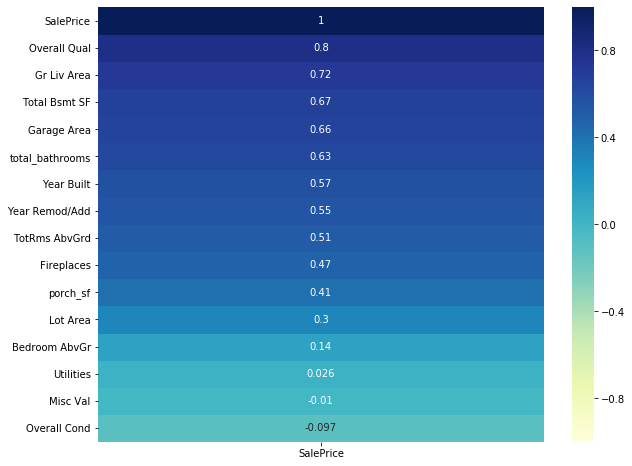

In [8]:
# Explore correlation to target:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df[features_target].corr()[['SalePrice']].sort_values('SalePrice').head(20),
            vmax=1, vmin=-1, cmap='YlGnBu', annot=True, ax=ax);
ax.invert_yaxis()

## High correlation with target:

We see that Overall quality has a strong correlation with the target value (0.8), and it is advisable to drop the overall quality feature. The rest of the correlation seems to be reasonable.

In [9]:
# Explore multi-collinearity:
corr = df[features_target].corr().abs()
unstack_corr = corr.unstack()
corr_sort = unstack_corr.sort_values(ascending = False)

print(corr_sort[15:30])

Lot Area         Lot Area           1.000000
Gr Liv Area      TotRms AbvGrd      0.809118
TotRms AbvGrd    Gr Liv Area        0.809118
SalePrice        Overall Qual       0.803462
Overall Qual     SalePrice          0.803462
Gr Liv Area      SalePrice          0.719463
SalePrice        Gr Liv Area        0.719463
TotRms AbvGrd    Bedroom AbvGr      0.679696
Bedroom AbvGr    TotRms AbvGrd      0.679696
SalePrice        Total Bsmt SF      0.665116
Total Bsmt SF    SalePrice          0.665116
SalePrice        Garage Area        0.655097
Garage Area      SalePrice          0.655097
total_bathrooms  SalePrice          0.632542
SalePrice        total_bathrooms    0.632542
dtype: float64


## High correlation with each other:

From the correlation table, we can see that General living area and Total rooms above grade are highly correlated. Judging that Gr Liv Area has a larger variance across houses as compared to a discrete column of total rooms above grade, the feature TotRms AbvGrd would be dropped.

In [10]:
features = [col for col in features if col not in ('TotRms AbvGrd', 'Overall Qual')]

In [11]:
# Define the feature
X = df[features]

## Polynomial Features

In consideration for sale price which is a continuous variable, I would look at the polynomial interaction effects of all numeric features

In [12]:
# Separate numeric and nominal features
num_feats = [col for col in df[features] if df[col].dtypes != 'object']
X_num = df[num_feats]
# Generating all polynomial features
poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
X_poly = poly.fit_transform(X_num)

In [13]:
# Get dataframe of Polynomial features
X_num_poly = pd.DataFrame(X_poly, columns = poly.get_feature_names(X_num.columns))

In [14]:
# Recombining numeric and nominal features
nom_feats = [col for col in df[features] if df[col].dtypes == 'object']
X = pd.concat([X_num_poly, df[nom_feats]], axis=1)

In [15]:
# Create dummies for nominal features
X = pd.get_dummies(X, drop_first = True)

In [16]:
# Important to split out the train and test set here, and only use the train set for modeling.
# Add back the sale price column to the polynomial feature dataframe
X = pd.concat([X,df['SalePrice']],axis = 1)
# Add back the ID column for test submission at the end
X = pd.concat([X,df['Id']],axis = 1)

In [17]:
# split out the test and the train set manually 
test = X[X['SalePrice'].isnull()]
X = X[X['SalePrice'].notnull()]

In [18]:
# Separate out the target train and test sets
y = X['SalePrice']
# remove the target column in train set
X.drop(columns='SalePrice',inplace = True)

## Train test split, standardizing and modeling with Linear regression, Lasso and Ridge

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

## Standardizing

In [20]:
# Standardizing
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train = stdsc.transform(X_train)
X_test = stdsc.transform(X_test)

## Linear Regression

In [21]:
# Assume linear regression as target is continuous variable
linreg = LinearRegression()
linreg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
# Linear regression metrics
print("LR cross_val_score", cross_val_score(linreg, X_train, y_train, cv=5).mean())
print('LR train r2 =', linreg.score(X_train, y_train))
print('LR test r2 =', linreg.score(X_test, y_test))
mse = mean_squared_error(y_test, linreg.predict(X_test))
print('LR MSE =', mse)

LR cross_val_score -2.4251654469101097e+19
LR train r2 = 0.9236393501829049
LR test r2 = -4.990231285405756e+18
LR MSE = 2.9766680765545263e+28


## LassoCV model

In [23]:
lasso = LassoCV(n_alphas=3000,cv=5,n_jobs=-1)
lasso.fit(X_train,y_train)

C:\Users\n3rDx\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 35148501975.05469, tolerance: 1042865239.731502
  positive)


LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=3000, n_jobs=-1, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [24]:
# Lasso metrics
print('Lasso train r2 =', lasso.score(X_train, y_train))
print('Lasso test r2 =', lasso.score(X_test, y_test))
mse = mean_squared_error(y_test, lasso.predict(X_test))
print('Lasso MSE =', mse)

Lasso train r2 = 0.9087103509205867
Lasso test r2 = 0.9112385694107505
Lasso MSE = 529461064.53429925


## RidgeCV model

In [25]:
ridge = RidgeCV(alphas=np.linspace(.01, 100, 2000))
ridge.fit(X_train,y_train)

RidgeCV(alphas=array([1.0000000e-02, 6.0020010e-02, 1.1004002e-01, ..., 9.9899960e+01,
       9.9949980e+01, 1.0000000e+02]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [26]:
print('Ridge train r2 =', ridge.score(X_train, y_train))
print('Ridge test r2 =', ridge.score(X_test, y_test))
mse = mean_squared_error(y_test, ridge.predict(X_test))
print('Ridge MSE =', mse)

Ridge train r2 = 0.914727151113387
Ridge test r2 = 0.8446813961362261
Ridge MSE = 926473951.5549773


## Model comparison

As comparing between the train set and the test set, we see that the difference is highest in linear regression as it is not regularised. Also, the mean square error is highest in this model. However, after regularisation, we see that the difference between r2 in test and train set is much smaller. More distictively, in the lassoCV model, we see that the model has high generalisability with r2 in train and test set of >0.9.

In [27]:
coef = pd.Series(lasso.coef_, index = (X.columns))

Text(0.5, 1.0, 'Feature importance using Lasso Model')

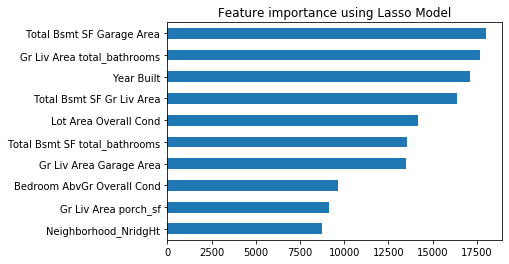

In [28]:
# Positively impacting features sorted
imp_coef = coef.sort_values().tail(10)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

Looking at the coefficients of the features in the LassoCV model, it is surprising to see that the year of which the house is build is a strong factor in predicting the sale price of the house. We see that the interaction between the total available living space and also the number of total bathrooms is also an important factor, as one may look at comfort and available utilities in the house to predicting sale price. Of course, the larger and the more facilities a house has, the more expensive it should be. This is shown with the subsequent features which are interaction terms between square feet of various features. The next stronger predictor seems to be in the neighborhood, as we see that certain neighborhood are more luxurious/high-end.

Text(0.5, 1.0, 'Feature that hurt sale prices using Lasso Model')

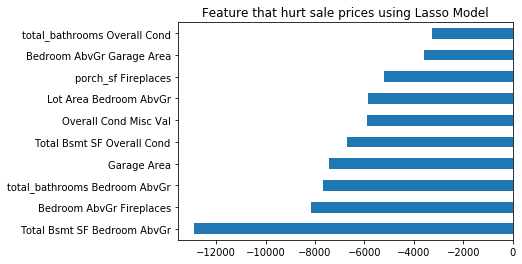

In [29]:
# Negatively impacting features sorted
neg_coef = coef.sort_values().head(10)
neg_coef.plot(kind = "barh")
plt.title("Feature that hurt sale prices using Lasso Model")

# Recommendations and business inferences
From the graphs above, we see that the interaction between total basement square feet and number of bedrooms above grade negatively affects the final sale price the most. More specifically, the larger the total basement square feet, the more likely that the house will be cheap, and the same is true for the total bedrooms above grade interpretation.

This may be interpreted as having lesser ground living area and less room space in each bedrooms above grade which eventually leads to a lower evaluation of the house being sold. This is also further supported above where we see that the interaction between total basement square feet and total ground living area has a large impact on sale price. People would buy houses that has the largest lot area in this consideration, but the lot area needs to depend on the space of each facilities (kitchen/basement/bedrooms/bathrooms). It is more likely that each facilities must be considered in tandem with the space available to predict the sale price.

A surprising point to note however, would be that garage area negatively impacts sale price. Intuitively, we would think that the larger the garage area, the more space we have for storage and for housing our own transportation. However from outside research, we see that a garage wasn't always a part of the normal American house, until ford started mass-production in 1913. As size and number of car owners increased, so would have garage area to house them. This feature should have likely interacted with the MS Zoning, where we would more likely see that in the dense residential area where it is more modernised with transportation and dense-filled developments, the need for garage area should be less pronounced than in MS zones that are less dense and less developed, where the need for cars for transportation is stronger.

## Submission of scores

In [30]:
test.drop(columns='SalePrice',inplace = True)

In [32]:
# Get predicted scores from our model above
predict = lasso.predict(test)
submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice':predict
})

In [35]:
submission.head()

Id     SalePrice
0  2658  7.113061e+10
1  2718  1.165211e+11
2  2414  4.339394e+10
3  1989  4.843963e+10
4   625  7.325862e+10

In [36]:
submission.to_csv('../datasets/submissions.csv', index=False)

In [38]:
#plt.scatter(x=lasso_overfit_preds, y=y_test, c='r')
plt.figure(figsize=(8,8))
m,b = np.polyfit(x=predict, y=y_test, deg=1)
plt.plot(predict, y_test, '.')
plt.plot(predict, b + m * predict, '-', color='k')
frame1 = plt.gca()
#frame1.axes.get_xaxis().set_ticks([])
#frame1.axes.get_yaxis().set_ticks([])
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.title('Predicted Sale Price vs Actual Sale Price')

TypeError: expected x and y to have same length

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Predicted Sale Price vs Actual Sale Price')

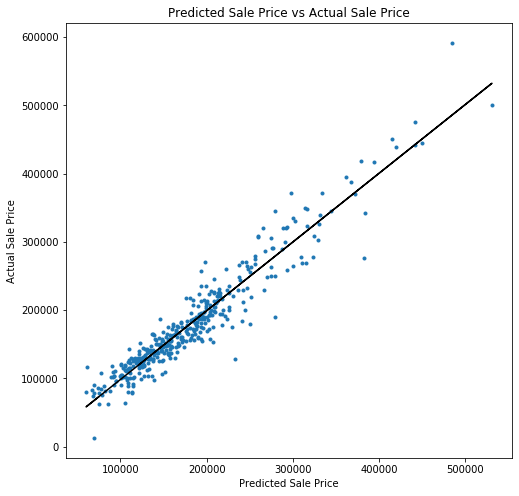

In [41]:
#plt.scatter(x=lasso_overfit_preds, y=y_test, c='r')
plt.figure(figsize=(8,8))
m,b = np.polyfit(x=lasso.predict(X_test), y=y_test, deg=1)
plt.plot(lasso.predict(X_test), y_test, '.')
plt.plot(lasso.predict(X_test), b + m * lasso.predict(X_test), '-', color='k')
frame1 = plt.gca()
#frame1.axes.get_xaxis().set_ticks([])
#frame1.axes.get_yaxis().set_ticks([])
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price')
plt.title('Predicted Sale Price vs Actual Sale Price')